# Определение перспективного тарифа для телеком-компании

### Описание проекта

Отдел аналитики компании «Мегалайн» — федерального оператора сотовой связи. 

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Нужно сделать предварительный анализ тарифов на небольшой выборке клиентов. 

Дла анализа есть данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

**Тариф «Смарт»**

Ежемесячная плата: 550 рублей

Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

минута разговора: 3 рубля

сообщение: 3 рубля

1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

Ежемесячная плата: 1950 рублей

Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

минута разговора: 1 рубль

сообщение: 1 рубль

1 Гб интернет-трафика: 150 рублей

## Подготовка данных


### Изменение типов данных

In [1]:
import pandas as pd #импорт библиотек
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

Чтение файлов с данными и сохранение в датафреймы.

In [2]:
try: # чтение файла с сайта
    calls = pd.read_csv('/datasets/calls.csv') 
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')
except: # чтение файла локально
    calls = pd.read_csv('datasets\calls.csv') 
    internet = pd.read_csv('datasets\internet.csv')
    messages = pd.read_csv('datasets\messages.csv')
    tariffs = pd.read_csv('datasets\\tariffs.csv')
    users = pd.read_csv('datasets\\users.csv')

Посмотрим на полученные данные.

In [3]:
# функция для обзора дотафрейма
def review_df(df):    
    display(df.head())
    print('--------------------------------------')
    print('Размер:')
    print(df.shape)
    print('--------------------------------------')
    print('Информация:')
    print(df.info())
    print('--------------------------------------')
    print('Дубликаты:')
    print(df.duplicated().sum())
    print('--------------------------------------')
    print('Пропуски:')
    print(df.isna().sum())
    print('--------------------------------------')
    print('Описание данных:')
    display(df.describe(include='all'))

#### Таблица сalls 

Таблица calls (информация о звонках):

* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

In [4]:
review_df(calls)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


--------------------------------------
Размер:
(202607, 4)
--------------------------------------
Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
--------------------------------------
Дубликаты:
0
--------------------------------------
Пропуски:
id           0
call_date    0
duration     0
user_id      0
dtype: int64
--------------------------------------
Описание данных:


,id,call_date,duration,user_id
count,202607,202607,202607.000000,202607.000000
unique,202607,365,NaN,NaN
top,1000_0,2018-12-31,NaN,NaN
freq,1,1435,NaN,NaN
mean,NaN,NaN,6.755887,1253.940619
std,NaN,NaN,5.843365,144.722751
min,NaN,NaN,0.000000,1000.000000
25%,NaN,NaN,1.300000,1126.000000
50%,NaN,NaN,6.000000,1260.000000
75%,NaN,NaN,10.700000,1379.000000


Количество ненулевых значений совпадает с количеством строк, пропусков нет. 

Столбец 'call_date' содержит дату. Изменим тип данных на дату.

In [5]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['call_date'].head(3) #посмотрим на результат и тип данных


0   2018-07-25
1   2018-08-17
2   2018-06-11
Name: call_date, dtype: datetime64[ns]

Столбец 'duration' хранит продолжительность звонка. «Мегалайн» всегда округляет секунды до минут. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Изменим тип данных на целочисленный.

In [6]:
display(calls['duration'].head(5))
# округляем в большую сторону и приводим к типу int64
calls['duration'] = calls['duration'].apply(np.ceil).astype('int64', errors = 'ignore')
calls['duration'].head(5)

0     0.00
1     0.00
2     2.85
3    13.80
4     5.18
Name: duration, dtype: float64

0     0
1     0
2     3
3    14
4     6
Name: duration, dtype: int64

Изменение прошло корректно.

#### Таблица internet 

Таблица internet (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

In [7]:
review_df(internet)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


--------------------------------------
Размер:
(149396, 5)
--------------------------------------
Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None
--------------------------------------
Дубликаты:
0
--------------------------------------
Пропуски:
Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64
--------------------------------------
Описание данных:


,Unnamed: 0,id,mb_used,session_date,user_id
count,149396.000000,149396,149396.000000,149396,149396.000000
unique,NaN,149396,NaN,365,NaN
top,NaN,1000_0,NaN,2018-12-31,NaN
freq,NaN,1,NaN,1057,NaN
mean,74697.500000,NaN,370.192426,NaN,1252.099842
std,43127.054745,NaN,278.300951,NaN,144.050823
min,0.000000,NaN,0.000000,NaN,1000.000000
25%,37348.750000,NaN,138.187500,NaN,1130.000000
50%,74697.500000,NaN,348.015000,NaN,1251.000000
75%,112046.250000,NaN,559.552500,NaN,1380.000000


Количество ненулевых значений совпадает с количеством строк, пропусков нет. 

Столбец 'session_date' содержит дату. Изменим тип данных на дату.

In [8]:
display(internet['session_date'].head(3))
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['session_date'].head(3) #посмотрим на результат и тип данных

0    2018-11-25
1    2018-09-07
2    2018-06-25
Name: session_date, dtype: object

0   2018-11-25
1   2018-09-07
2   2018-06-25
Name: session_date, dtype: datetime64[ns]

#### Таблица messages 

Таблица messages (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

In [9]:
review_df(messages)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


--------------------------------------
Размер:
(123036, 3)
--------------------------------------
Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None
--------------------------------------
Дубликаты:
0
--------------------------------------
Пропуски:
id              0
message_date    0
user_id         0
dtype: int64
--------------------------------------
Описание данных:


,id,message_date,user_id
count,123036,123036,123036.000000
unique,123036,364,NaN
top,1000_0,2018-12-31,NaN
freq,1,859,NaN
mean,NaN,NaN,1256.989410
std,NaN,NaN,143.523967
min,NaN,NaN,1000.000000
25%,NaN,NaN,1134.000000
50%,NaN,NaN,1271.000000
75%,NaN,NaN,1381.000000


Количество ненулевых значений совпадает с количеством строк, пропусков нет. 

Столбец 'message_date' содержит дату. Изменим тип данных на дату.

In [10]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['message_date'].head(3) #посмотрим на результат и тип данных

0   2018-06-27
1   2018-10-08
2   2018-08-04
Name: message_date, dtype: datetime64[ns]

#### Таблица tariffs 

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [11]:
review_df(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


--------------------------------------
Размер:
(2, 8)
--------------------------------------
Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None
--------------------------------------
Дубликаты:
0
--------------------------------------
Пропуски:
messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb      

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,smart
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000,NaN
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214,NaN
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000,NaN
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000,NaN
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000,NaN
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000,NaN


#### Таблица users 

Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

In [12]:
review_df(users)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


--------------------------------------
Размер:
(500, 8)
--------------------------------------
Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
--------------------------------------
Дубликаты:
0
--------------------------------------
Пропуски:
user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64
--------------------------------------
Описание данных:


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
count,500.000000,500.00000,38,500,500,500,500,500
unique,NaN,NaN,33,76,246,419,270,2
top,NaN,NaN,2018-12-03,Москва,Радим,Андреенко,2018-05-28,smart
freq,NaN,NaN,2,99,6,5,8,351
mean,1249.500000,46.58800,NaN,NaN,NaN,NaN,NaN,NaN
std,144.481833,16.66763,NaN,NaN,NaN,NaN,NaN,NaN
min,1000.000000,18.00000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1124.750000,32.00000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1249.500000,46.00000,NaN,NaN,NaN,NaN,NaN,NaN
75%,1374.250000,62.00000,NaN,NaN,NaN,NaN,NaN,NaN


Количество заполненных значений совпадает с количеством строк, кроме столбца 'churn_date', где это означает, что тариф еще действует на момент выгрузки данных.

Столбец 'reg_date' содержит дату. Изменим тип данных на дату.

In [13]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['reg_date'].head(3) #посмотрим на результат и тип данных

0   2018-05-25
1   2018-11-01
2   2018-06-17
Name: reg_date, dtype: datetime64[ns]

Изменим тип в столбцу 'churn_date'.

Только ненулевые значения:

In [14]:
users.loc[users['churn_date'].notna(), 'churn_date'].head(10) 

19    2018-10-05
20    2018-12-18
34    2018-11-21
50    2018-10-03
51    2018-10-14
56    2018-10-14
62    2018-12-09
63    2018-12-11
64    2018-12-26
65    2018-12-09
Name: churn_date, dtype: object

Изменим в них тип:

In [15]:
users.loc[users['churn_date'].notna(), 'churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users.loc[users['churn_date'].notna(), 'churn_date'].head(10)  #посмотрим на результат

19    2018-10-05 00:00:00
20    2018-12-18 00:00:00
34    2018-11-21 00:00:00
50    2018-10-03 00:00:00
51    2018-10-14 00:00:00
56    2018-10-14 00:00:00
62    2018-12-09 00:00:00
63    2018-12-11 00:00:00
64    2018-12-26 00:00:00
65    2018-12-09 00:00:00
Name: churn_date, dtype: object

Проверим тип данных:

In [16]:
users.loc[19, 'churn_date']

Timestamp('2018-10-05 00:00:00')

Подойдёт.

### Исправление ошибок.

#### Таблица сalls 

In [17]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


Проверим столбец duration на ошибки.

In [18]:
calls['duration'].describe()

count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

Столбец duration - продолжительность разговора. 
Продолжительность от 0 до 38 минут, медиана - 6 минут. Всё нормально, правдоподобно.

In [19]:
calls_grouped = calls.groupby(by = 'user_id')

In [20]:
calls_grouped.count()

,id,call_date,duration
user_id,,,
1000,368,368,368
1001,122,122,122
1002,217,217,217
1003,520,520,520
1004,176,176,176
...,...,...,...
1495,565,565,565
1496,828,828,828
1497,201,201,201


Всего 492 пользователей, по которым хранятся данные.

In [21]:
calls_grouped['id'].count().describe()

count     492.000000
mean      411.802846
std       291.803375
min        14.000000
25%       180.000000
50%       344.500000
75%       589.500000
max      1760.000000
Name: id, dtype: float64

- Среднее количество звонков равно 411 в месяц.
- Медиана составила 344 звонка.
- Максимум - 1760. 

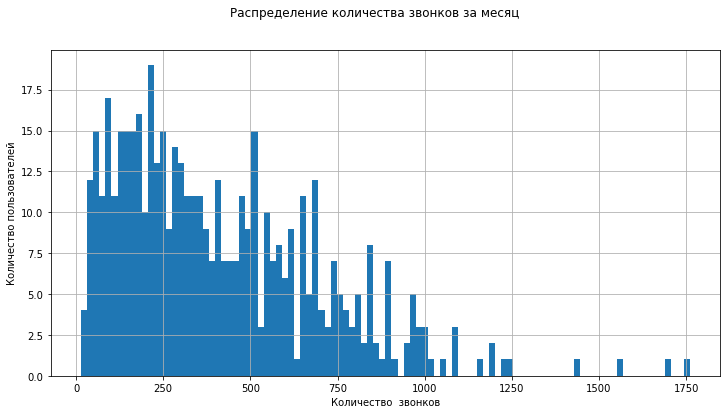

In [22]:
plt.suptitle('Распределение количества звонков за месяц')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество  звонков')
calls_grouped['id'].count().hist(bins = 100, figsize = (12,6))
plt.show;

Вначале график возрастает, затем плавно убывает, показывая распределение Пуассона. 

Максимум находится вокруг 250 звонков в месяц. 


In [23]:
calls_grouped['duration'].sum().describe()

count      492.000000
mean      2947.766260
std       2091.001034
min         66.000000
25%       1291.500000
50%       2478.000000
75%       4227.000000
max      12973.000000
Name: duration, dtype: float64

Средняя продолжительность разговоров в месяц на одного пользователя составила 2947 минут.

Медианное значение равно 2478 минут.

Минимум - 66 минут, максимум - 12973 минуты.

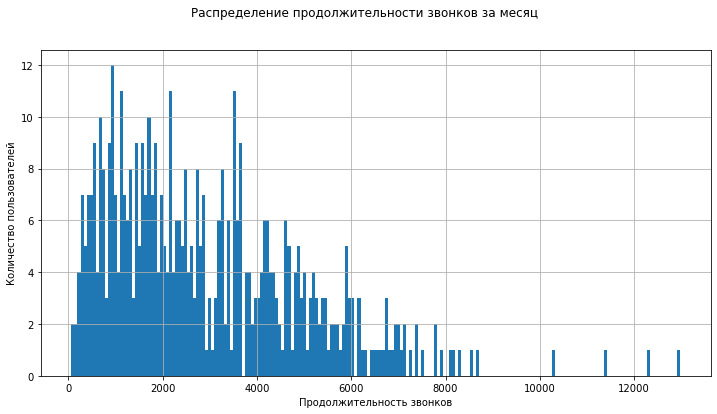

In [24]:
plt.suptitle('Распределение продолжительности звонков за месяц')
plt.ylabel('Количество пользователей')
plt.xlabel('Продолжительность звонков')
calls_grouped['duration'].sum().hist(bins = 200, figsize = (12,6));

Вначале график возрастает, затем плавно убывает, показывая распределение Пуассона. 

Максимум находится около 800 минут в месяц. 


#### Таблица internet 

In [25]:
internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


Столбец 'Unnamed: 0' дублирует индексацию, не хранит никакой полезной информации и может быть удалён без потери данных.


In [26]:
internet = internet[['id', 'mb_used', 'session_date', 'user_id']]
internet.head(10)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [27]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Максимум данных за сессию - 1724 Мб, это 1,68 Гб.
Медианное значение - 370 Мб.
Кажется, всё нормально.

Больше видимых ошибок нет.

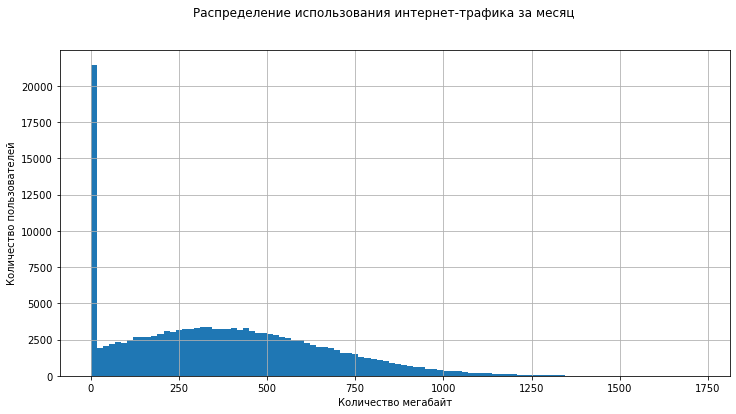

In [28]:
plt.suptitle('Распределение использования интернет-трафика за месяц')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество мегабайт')
internet['mb_used'].hist(bins = 100, figsize = (12,6));

Большой выброс в нуле. Многие пользователи не используют мобильный интернет. 

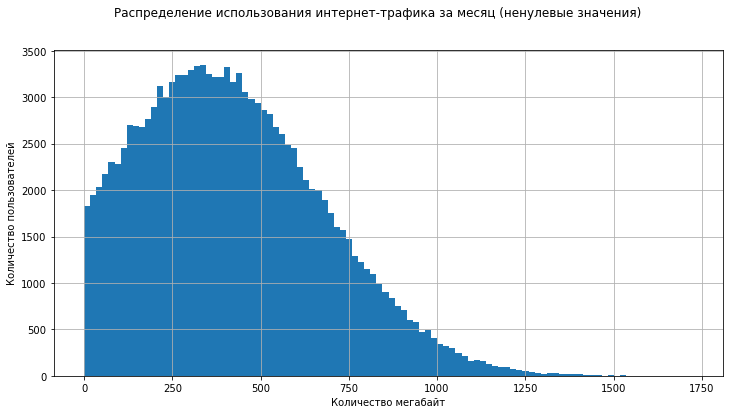

In [29]:
plt.suptitle('Распределение использования интернет-трафика за месяц (ненулевые значения)')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество мегабайт')
internet.loc[internet['mb_used']>0]['mb_used'].hist(bins = 100, figsize = (12,6));

Распределение Пуассона очень красноречиво. Среди пользователей мобильного интернета большинство используют до 700 МБ за месяц.

#### Таблица messages 

In [30]:
messages.head(5)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [31]:
messages.groupby(by = 'user_id').count()

,id,message_date
user_id,,
1000,496,496
1002,70,70
1003,380,380
1004,1192,1192
1005,552,552
...,...,...
1495,340,340
1496,468,468
1497,51,51


Всего 426 пользователей, по которым хранятся данные.

In [32]:
messages.groupby(by = 'user_id')['id'].count().describe()

count     426.000000
mean      288.816901
std       267.607552
min         1.000000
25%        85.750000
50%       215.500000
75%       414.000000
max      1463.000000
Name: id, dtype: float64

Среднее количество сообщений равно 288 в месяц,

Медиана составила 215 сообщений.

Максимум - 1463. 

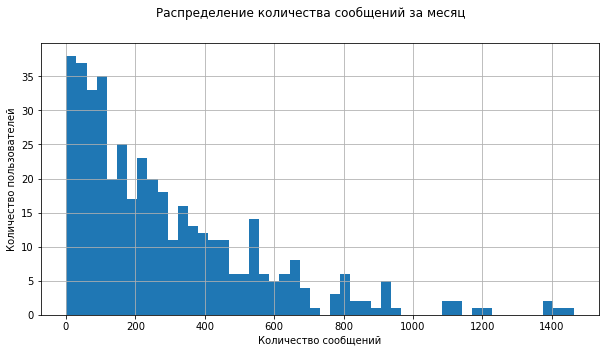

In [33]:
plt.suptitle('Распределение количества сообщений за месяц')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество сообщений')
messages.groupby(by = 'user_id')['id'].count().hist(bins = 50, figsize = (10,5));

Гистограмма выглядит правдоподобно, большинство пользователей отправляют меньше 300 сообщений в месяц.

Ошибок не найдено. 

#### Таблица tariffs 

In [34]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица небольшая, содержит только данные о тарифных ограничениях и стоимости. Ошибок и дубликатов нет.

#### Таблица users 

In [35]:
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Все данные выглядят нормально.

In [36]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


Для подсчёта создадим столбец с месяцем совершения звонка.

In [37]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


In [38]:
calls_pivot = calls.pivot_table(
    index = ['user_id', 'month'], # группируем по столбцу user_id и 'month'
    values = 'duration', # в качестве значений столбец duration
    aggfunc = ['count','sum'] # считаем количество звонков и сумму продолжительностей
).reset_index( # перезадаём индекс
)
calls_pivot.columns = ['user_id','month','count_calls', 'sum_duration_calls'] # переименовываем столбцы
calls_pivot.head(5)

,user_id,month,count_calls,sum_duration_calls
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


#### Таблица internet 

In [39]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Для подсчёта создадим столбец с месяцем.

In [40]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


In [41]:
internet_pivot = internet.pivot_table(
    index = ['user_id', 'month'], # группируем по столбцу user_id и month
    values = 'mb_used', # в качестве значений столбец mb_used
    aggfunc = 'sum' # считаем объем израсходованного интернет-трафика
).reset_index( # перезадаём индекс
)
internet_pivot.head(10)

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
5,1000,10,14702.49
6,1000,11,14756.47
7,1000,12,9817.61
8,1001,11,18429.34
9,1001,12,14036.66


«Мегалайн» всегда округляет мегабайты до гигабайт.
Отдельные сессии не считаются. 

Вместо этого общая сумма за месяц округляется в бо́льшую сторону. 

Переведём мегабайты за месяц в гигабайты и округлим вверх:

In [42]:
internet_pivot['gb_used'] = internet_pivot['mb_used']/1024 # переводим в гигабайты
internet_pivot['gb_used'] = internet_pivot['gb_used'].apply(np.ceil).astype('int64') # округляем в большую сторону
internet_pivot.head() # смотрим, что получилось

,user_id,month,mb_used,gb_used
0,1000,5,2253.49,3
1,1000,6,23233.77,23
2,1000,7,14003.64,14
3,1000,8,14055.93,14
4,1000,9,14568.91,15


In [43]:
internet_pivot = internet_pivot[['user_id','month','gb_used']] # убираем ставший ненужным столбец
internet_pivot.head()

,user_id,month,gb_used
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15


#### Таблица messages 

In [44]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Для подсчёта создадим столбец с месяцем.

In [45]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [46]:
messages_pivot = messages.pivot_table(
    index = ['user_id', 'month'],      # группируем по столбцу user_id и month
    values = 'id', # 
    aggfunc = 'count' 
).reset_index()
messages_pivot.columns = ['user_id','month','count_messages'] 
messages_pivot.head(10)

,user_id,month,count_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


#### Объединение таблиц

Создадим общую таблицу df, где будут все необходимые данные для расчётов.

In [47]:
df = calls_pivot.merge(                   # к сводной таблице звонков
    internet_pivot,                       # присоединяем сводную таблицу с интернет-трафиком
    on = ['user_id', 'month'],            # нужно объединять по двум столбцам
    how = 'outer'                         # нам нужны все столбцы
).merge(                                  # далее присоединяем
    messages_pivot,                       # сводную таблицу с сообщениями
    on = ['user_id', 'month'],            # нужно объединять по двум столбцам
    how = 'outer'                         # нам нужны все столбцы
).merge(                                  # далее присоединяем
    users[['user_id', 'tariff', 'city']], # только эти столбцы таблицы пользователей
    on = 'user_id',                       # по столбцу user_id добавится тариф и город этого пользователя
    how = 'outer'                         # нам нужны все столбцы
).merge(                                  # далее присоединяем
    tariffs.rename(columns = {'tariff_name':'tariff'}), # чтобы всё сошлось
    on = 'tariff',                        # по столбцу tariff добавятся все характеристики этого тарифа
    how = 'outer'                         # нам нужны все столбцы
)
df.head(5)

,user_id,month,count_calls,sum_duration_calls,gb_used,count_messages,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,22.0,159.0,3.0,22.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
1,1000,6.0,43.0,172.0,23.0,60.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
2,1000,7.0,47.0,340.0,14.0,75.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
3,1000,8.0,52.0,408.0,14.0,81.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
4,1000,9.0,58.0,466.0,15.0,57.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1


In [48]:
df.shape

(3216, 15)

#### Расчёт выручки 

Напишем функцию, которая считает ежемесячную выручку с каждого пользователя:
1) вычитает бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;

2) остаток умножает на значение из тарифного плана; 

3) прибавляет абонентскую плату, соответствующую тарифному плану

In [49]:
def revenue_month_user (row):
    try:
        payed_minutes = row['sum_duration_calls'] - row['minutes_included']
        payed_messages =  row['count_messages'] - row['messages_included']
        payed_gb = row['gb_used'] - (row['mb_per_month_included']/1024)
        revenue = 0
        if payed_minutes > 0:
            revenue += payed_minutes*row['rub_per_minute']
        if payed_messages > 0:
            revenue += payed_messages*row['rub_per_message']
        if payed_gb > 0:
            revenue += payed_gb*row['rub_per_gb']
        revenue += row['rub_monthly_fee']
        return revenue
    except:
        return 'в данных ошибка'

In [50]:
df['revenue'] = df.apply(revenue_month_user, axis=1) # применяем функцию к строкам датафрейма

In [51]:
len(df[df['revenue'] == 'в данных ошибка']) # проверим, нет ли ошибок

0

Ошибок нет.

In [52]:
df.sample(5) # просмотр и контроль работы функции

,user_id,month,count_calls,sum_duration_calls,gb_used,count_messages,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
1613,1136,12.0,64.0,471.0,31.0,90.0,smart,Липецк,50,15360,500,550,200,3,3,3870.0
3188,1496,2.0,77.0,594.0,28.0,45.0,smart,Вологда,50,15360,500,550,200,3,3,3432.0
138,1089,3.0,83.0,626.0,18.0,155.0,ultra,Иркутск,1000,30720,3000,1950,150,1,1,1950.0
2606,1366,10.0,38.0,254.0,7.0,44.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3,550.0
3134,1482,5.0,59.0,360.0,13.0,61.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3,583.0


In [53]:
df['revenue'].describe() 

count    3216.000000
mean     1528.902674
std       798.224060
min       550.000000
25%       750.000000
50%      1653.500000
75%      1950.000000
max      6770.000000
Name: revenue, dtype: float64

Значения от 550 (абонентская плата за тариф Smart) до 6770 рублей, среднее 1528 рублей, медиана 1653 рубля.  

Посмотрим на график выручки для пользователей обоих тарифов:

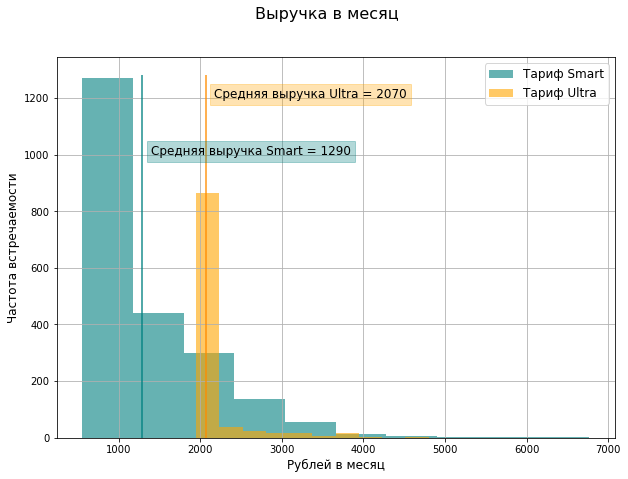

In [54]:
revenue_smart = df[df['tariff'] == 'smart']['revenue']   # выручка на тарифе Смарт
mean_revenue_smart = round(revenue_smart.mean())         # посчитаем среднюю выручку
mean_revenue_smart_label = f'Cредняя выручка Smart = {mean_revenue_smart}' # сделаем подпись
revenue_ultra = df[df['tariff'] == 'ultra']['revenue']   # выручка на тарифе Ультра
mean_revenue_ultra = round(revenue_ultra.mean())         # посчитаем среднюю выручку
mean_revenue_ultra_label = f'Cредняя выручка Ultra = {mean_revenue_ultra}' # сделаем подпись

plt.figure(figsize=(10, 7))       # размер
plt.suptitle('Выручка в месяц', fontsize = 16)   # заголовок 

t1 = plt.text (mean_revenue_smart+100, 1000, mean_revenue_smart_label, fontsize = 12)
t1.set_bbox(dict(facecolor='teal', alpha=0.3, edgecolor='teal'))
# подпись средней выручки
plt.vlines (mean_revenue_smart, 0, 1280, color = 'teal', alpha = 0.9)  # линия средней выручки

t2 = plt.text (mean_revenue_ultra+100, 1200, mean_revenue_ultra_label, fontsize = 12)
t2.set_bbox(dict(facecolor='orange', alpha=0.3, edgecolor='orange'))
# подпись средней выручки
plt.vlines (mean_revenue_ultra, 0, 1280, color = 'darkorange', alpha = 0.9)  # линия средней выручки
plt.grid(True)
plt.hist(revenue_smart,  alpha = 0.6, label='Тариф Smart', color = 'teal')    # первый график
plt.hist(revenue_ultra,  alpha = 0.6, label='Тариф Ultra', color = 'orange')  # второй график
plt.xlabel('Рублей в месяц', fontsize = 12)            # подпись горизонтальной оси 
plt.ylabel('Частота встречаемости', fontsize = 12)     # подпись вертикальной оси  
plt.legend(loc='upper right', fontsize = 12)           # легенда 
plt.show()

График показывает, что пользователи тарифа  в среднем приносят больше выручки, но их количество меньше.

## Анализ данных

Посмотрим, сколько пользователей на каждом тарифе.

In [55]:
df['tariff'].value_counts() 

smart    2230
ultra     986
Name: tariff, dtype: int64

### Пользовательское поведение


#### Пользователи с тарифом "Smart"

In [56]:
df[df['tariff'] == 'smart'].head()

,user_id,month,count_calls,sum_duration_calls,gb_used,count_messages,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
986,1001,11.0,59.0,430.0,18.0,NaN,smart,Москва,50,15360,500,550,200,3,3,1150.0
987,1001,12.0,63.0,414.0,14.0,NaN,smart,Москва,50,15360,500,550,200,3,3,550.0
988,1002,6.0,15.0,117.0,11.0,4.0,smart,Стерлитамак,50,15360,500,550,200,3,3,550.0
989,1002,7.0,26.0,214.0,18.0,11.0,smart,Стерлитамак,50,15360,500,550,200,3,3,1150.0
990,1002,8.0,42.0,289.0,20.0,13.0,smart,Стерлитамак,50,15360,500,550,200,3,3,1550.0


Посмотрим описание данных:

In [57]:
df[df['tariff'] == 'smart'][['sum_duration_calls','count_messages','gb_used']].describe()

,sum_duration_calls,count_messages,gb_used
count,2223.000000,1922.000000,2228.000000
mean,419.062978,38.716441,16.336176
std,189.325618,26.787949,5.737923
min,0.000000,1.000000,0.000000
25%,285.000000,17.000000,13.000000
50%,423.000000,34.000000,17.000000
75%,545.500000,55.000000,20.000000
max,1435.000000,143.000000,38.000000


Дисперсии:

In [58]:
print('Дисперсия продолжительности звонков:', '%.2f' % (np.var(df[df['tariff'] == 'smart']['sum_duration_calls'])))

Дисперсия продолжительности звонков: 35828.07


In [59]:
print('Дисперсия  количества сообщений:', '%.2f' % (np.var(df[df['tariff'] == 'smart']['count_messages'])))

Дисперсия  количества сообщений: 717.22


In [60]:
print('Дисперсия объёма интернет-трафика:', '%.2f' % (np.var(df[df['tariff'] == 'smart']['gb_used'])))

Дисперсия объёма интернет-трафика: 32.91


***Статистика звонков:***
* Среднее количество минут разговора - 419. 
* Стандартное отклонение - 189. Почти половина среднего.
* Дисперсия - 35828. Разброс большой.

***Статистика сообщений:***
* Среднее количество сообщений - 39.
* Стандартное отклонение  - 27. Почти три четверти среднего.
* Дисперсия - 717. Разброс большой.

***Статистика интернет-трафика:***
* Среднее количество гигибайт - 16,3.
* Стандартное отклонение  - 5,7.
* Дисперсия - 32,9. Разброс большой.

Построим частотную гистограмму продолжительности звонков:

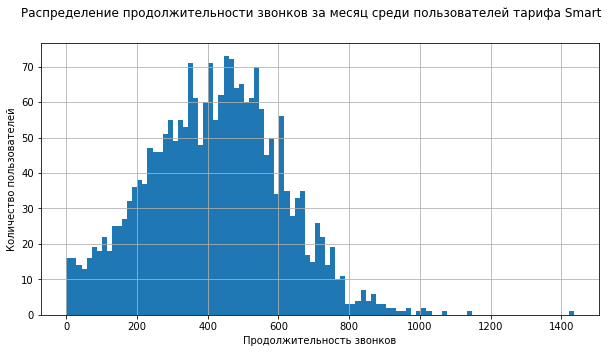

In [61]:
plt.suptitle('Распределение продолжительности звонков за месяц среди пользователей тарифа Smart')
plt.ylabel('Количество пользователей')
plt.xlabel('Продолжительность звонков')
df[
    df['tariff'] == 'smart' # только пользователи с тарифом Smart
]['sum_duration_calls'].hist(bins = 100, figsize = (10,5));

График похож на распределение Пуассона, вначале частота встречаемости значения увеличивается, достигает максимума от 250 до 600 минут, дальше плавно убывает с уменьшением частоты, потому что всё меньше пользователей говорят больше на этом тарифе.

Построим частотную гистограмму количества сообщений:

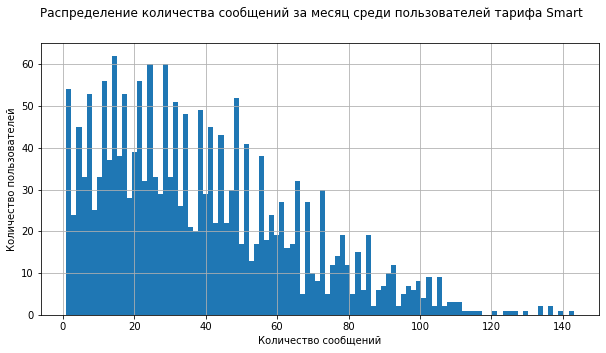

In [62]:
plt.suptitle('Распределение количества сообщений за месяц среди пользователей тарифа Smart')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество сообщений')
df[df['tariff'] == 'smart']['count_messages'].hist(bins = 100, figsize = (10,5));

График похож на распределение Пуассона, вначале частота встречаемости значения увеличивается, достигает максимума от 10 до 30 сообщений, дальше плавно убывает с уменьшением частоты, потому что всё меньше пользователей отправляют больше сообщений на этом тарифе.

Построим частотную гистограмму объёма трафика:

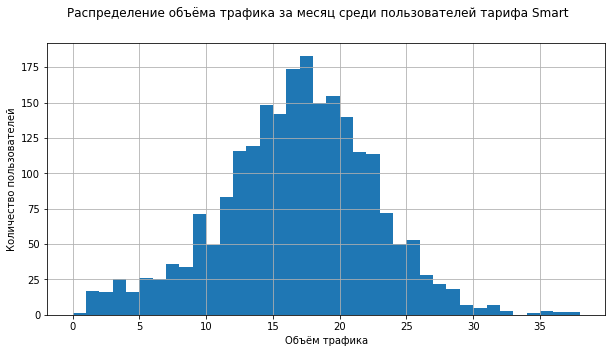

In [63]:
plt.suptitle('Распределение объёма трафика за месяц среди пользователей тарифа Smart')
plt.ylabel('Количество пользователей')
plt.xlabel('Объём трафика')
bins = int(max(df[df['tariff'] == 'smart']['gb_used']))
df[df['tariff'] == 'smart']['gb_used'].hist(bins = bins, figsize = (10,5));

График похож на нормальное распределение, вначале частота встречаемости значения увеличивается, достигает максимума от 12 до 22 Гб, дальше убывает с уменьшением частоты.

#### Пользователи с тарифом "Ultra"

In [64]:
df[df['tariff'] == 'ultra'].head()

,user_id,month,count_calls,sum_duration_calls,gb_used,count_messages,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,1000,5.0,22.0,159.0,3.0,22.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.0
1,1000,6.0,43.0,172.0,23.0,60.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.0
2,1000,7.0,47.0,340.0,14.0,75.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.0
3,1000,8.0,52.0,408.0,14.0,81.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.0
4,1000,9.0,58.0,466.0,15.0,57.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,1950.0


Посмотрим описание данных пользователей тарифа Ultra:

In [65]:
df[df['tariff'] == 'ultra'][['sum_duration_calls','count_messages','gb_used']].describe()

,sum_duration_calls,count_messages,gb_used
count,951.000000,795.000000,975.000000
mean,545.451104,61.161006,19.694359
std,306.925754,45.931026,9.702924
min,0.000000,1.000000,0.000000
25%,310.000000,24.000000,12.000000
50%,528.000000,51.000000,19.000000
75%,756.500000,87.500000,27.000000
max,1673.000000,224.000000,49.000000


In [66]:
print('Дисперсия продолжительности звонков:', np.var(df[df['tariff'] == 'ultra']['sum_duration_calls']))

Дисперсия продолжительности звонков: 94104.36117385981


In [67]:
print('Дисперсия количества сообщений:', np.var(df[df['tariff'] == 'ultra']['count_messages']))

Дисперсия количества сообщений: 2107.0055235156874


In [68]:
print('Дисперсия объёма интернет-трафика:', np.var(df[df['tariff'] == 'ultra']['gb_used']))

Дисперсия объёма интернет-трафика: 94.0501733070347


***Статистика звонков:***
* Среднее количество минут разговора - 545. 
* Стандартное отклонение - 307. Больше половины среднего.
* Дисперсия - 94104. Разброс очень большой.

***Статистика сообщений:***
* Среднее количество сообщений - 61.
* Стандартное отклонение  - 46. Больше двух третей среднего.
* Дисперсия - 2107. Разброс очень большой.

***Статистика интернет-трафика:***
* Среднее количество гигибайт - 19,7.
* Стандартное отклонение  - 9,7.
* Дисперсия - 94. Разброс большой.

Построим частотную гистограмму продолжительности звонков:

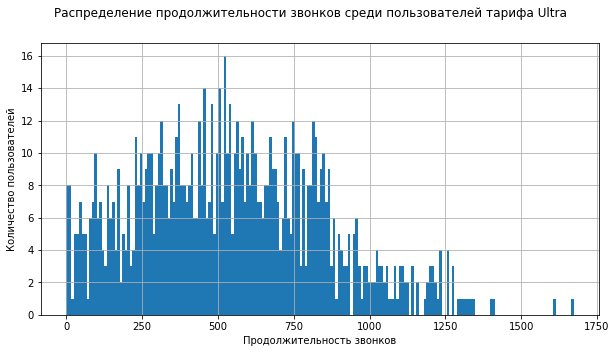

In [69]:
plt.suptitle('Распределение продолжительности звонков среди пользователей тарифа Ultra')
plt.ylabel('Количество пользователей')
plt.xlabel('Продолжительность звонков')
df[df['tariff'] == 'ultra']['sum_duration_calls'].hist(bins = 200, figsize = (10,5));

График похож на распределение Пуассона, вначале частота встречаемости значения увеличивается, достигает максимума от 250 до 900 минут, дальше плавно убывает с уменьшением частоты, потому что всё меньше пользователей говорят больше на этом тарифе. Больше 1300 - только единичные пользователи.

Построим частотную гистограмму количества сообщений:

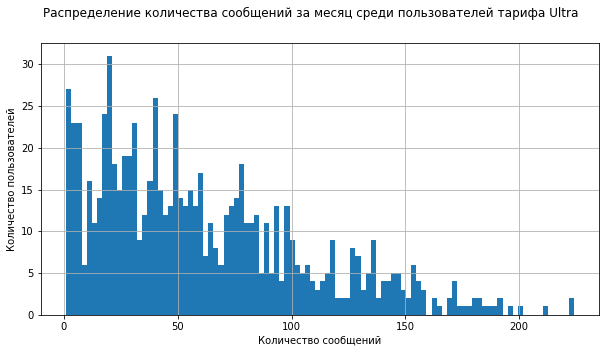

In [70]:
plt.suptitle('Распределение количества сообщений за месяц среди пользователей тарифа Ultra')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество сообщений')
df[df['tariff'] == 'ultra']['count_messages'].hist(bins = 100, figsize = (10,5));

График похож на распределение Пуассона, вначале частота встречаемости значения увеличивается, достигает максимума от 10 до 50 сообщений, дальше плавно убывает с уменьшением частоты, потому что всё меньше пользователей отправляют больше сообщений на этом тарифе.

Построим частотную гистограмму объёма трафика:

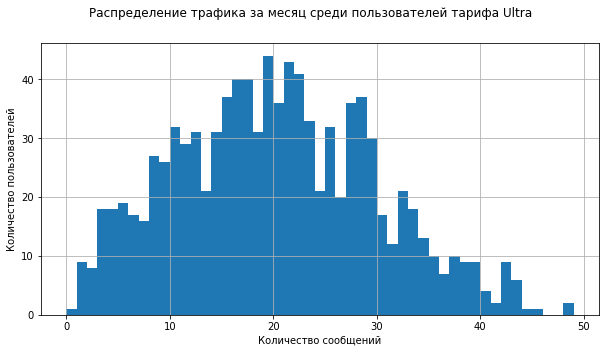

In [71]:
plt.suptitle('Распределение трафика за месяц среди пользователей тарифа Ultra')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество сообщений')
bins = int(max(df[df['tariff'] == 'ultra']['gb_used']))
df[df['tariff'] == 'ultra']['gb_used'].hist(bins = bins, figsize = (10,5));

График похож на нормальное распределение, вначале частота встречаемости значения увеличивается, достигает максимума от 8 до 30 Гб, дальше убывает с уменьшением частоты встречаемости.

#### Сравнение пользователей обоих тарифов

Для наглядности отразим вместе.

Построим сравнительную частотную гистограмму продолжительности звонков для обоих тарифов:

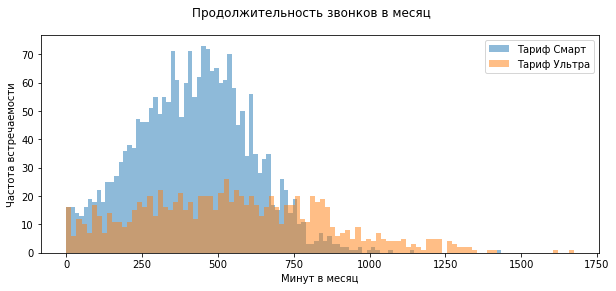

In [72]:
calls_smart = df[
    df['tariff'] == 'smart' # только пользователи с тарифом Smart
]['sum_duration_calls']

calls_ultra = df[
    df['tariff'] == 'ultra' # только пользователи с тарифом Ultra
]['sum_duration_calls']

plt.figure(figsize=(10, 4)) # размер
plt.suptitle('Продолжительность звонков в месяц') # заголовок 
plt.hist(calls_smart, bins = 100, alpha = 0.5, label='Тариф Смарт', ) # первый график
plt.hist(calls_ultra, bins = 100, alpha = 0.5, label='Тариф Ультра') # второй график
plt.xlabel('Минут в месяц')   # подпись горизонтальной оси 
plt.ylabel('Частота встречаемости') # подпись вертикальной оси  
plt.legend(loc='upper right') # легенда 
plt.show()

**Вывод:** График для тарифа Ультра уходит больше вправо, но количество пользователей этого тарифа меньше, поскольку большая часть графика ниже, чем для тарифа Смарт.

Построим сравнительную частотную гистограмму количества сообщений для обоих тарифов:

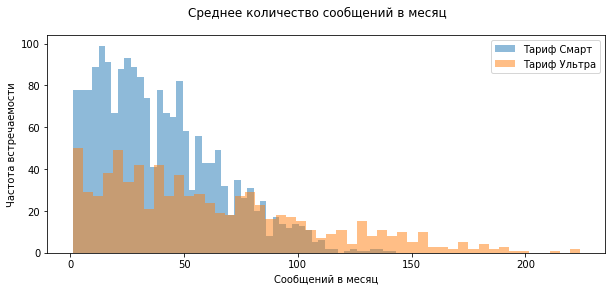

In [73]:
messages_smart = df[
    df['tariff'] == 'smart' # только пользователи с тарифом Smart
]['count_messages']

messages_ultra = df[
    df['tariff'] == 'ultra' # только пользователи с тарифом Ultra
]['count_messages']

plt.figure(figsize=(10 , 4)) # размер
plt.suptitle('Среднее количество сообщений в месяц') # заголовок 
plt.hist(messages_smart, bins = 50, alpha = 0.5, label='Тариф Смарт', ) # первый график
plt.hist(messages_ultra, bins = 50, alpha = 0.5, label='Тариф Ультра') # второй график
plt.xlabel('Сообщений в месяц')   # подпись горизонтальной оси 
plt.ylabel('Частота встречаемости') # подпись вертикальной оси  
plt.legend(loc='upper right') # легенда 
plt.show()

**Вывод:** График для тарифа Ультра уходит больше вправо, но количество пользователей этого тарифа меньше, поскольку большая часть графика ниже, чем для тарифа Смарт.

Построим сравнительную частотную гистограмму объёма трафика для обоих тарифов:

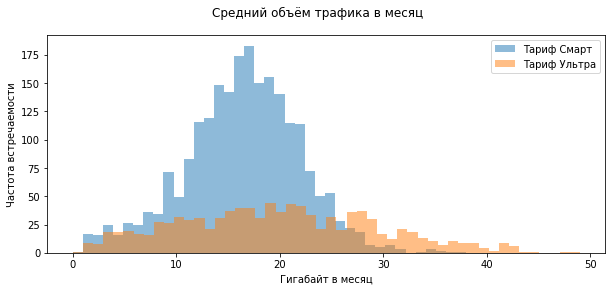

In [74]:
gb_smart = df[
    df['tariff'] == 'smart' # пользователи с тарифом Smart
]['gb_used'] 

gb_ultra = df[
    df['tariff'] == 'ultra' # пользователи с тарифом Ultra
]['gb_used']

plt.figure(figsize=(10, 4)) # размер
plt.suptitle('Средний объём трафика в месяц') # заголовок 
plt.hist(gb_smart, bins = 39, alpha = 0.5, label='Тариф Смарт', ) # первый график
plt.hist(gb_ultra, bins = 50, alpha = 0.5, label='Тариф Ультра') # второй график
plt.xlabel('Гигабайт в месяц')   # подпись горизонтальной оси 
plt.ylabel('Частота встречаемости') # подпись вертикальной оси  
plt.legend(loc='upper right') # легенда 
plt.show()

**Вывод:** График для тарифа Ультра уходит больше вправо, но количество пользователей этого тарифа меньше, поскольку большая часть графика ниже, чем для тарифа Смарт.

## Проверка гипотез

### Гипотеза 1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

*Нулевая гипотеза H₀ всегда формулируется так, чтобы использовать знак равенства.  Альтернативная гипотеза H₁ - это утверждение, которое принимается верным, если отбрасывается H₀.*

**Нулевая гипотеза: средние значения ежемесячной выручки пользователей тарифов "Smart" и "Ultra" равны.**

*Альтернативная гипотеза: Средние значения ежемесячной выручки пользователей тарифов "Smart" и "Ultra" отличаются.*

Посмотрим, сколько пользователей на каждом тарифе.

In [75]:
df['tariff'].value_counts() 

smart    2230
ultra     986
Name: tariff, dtype: int64

Дисперсии: 

In [76]:
print('Дисперсия выручки для тарифа Smart:', '%.2f' % (np.var(df[df['tariff'] == 'smart']['revenue'])))

Дисперсия выручки для тарифа Smart: 669430.44


In [77]:
print('Дисперсия выручки для тарифа Ultra:', '%.2f' % (np.var(df[df['tariff'] == 'ultra']['revenue'])))

Дисперсия выручки для тарифа Ultra: 141244.32


Зададим уровень значимости в 5%, чтобы вероятность получить такое или большее различие между средними значениями выборки случайно было меньше 5%.

Проведём T-тест.
Если результат меньше 5%, то нулевую гипотезу следует отвергнуть.

* Размеры выборок отличаются (2230 и 986 значений)
* Дисперсии выборок отличаются (669430 и 141244)

Следовательно, зададим параметр, задающий равенство выборок "equal_var" = False

In [78]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    df[df['tariff'] == 'smart']['revenue'], # первая выборка
    df[df['tariff'] == 'ultra']['revenue'],  # вторая выборка
    equal_var = False 
)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


Вероятность получить такое различие средних крайне мала. Около 10 в минус 250 степени.

**Результат означает, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.**

### Гипотеза 2: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**Нулевая гипотеза: средние значения ежемесячной выручки пользователей из Москвы и регионов равны.**

*Альтернативная гипотеза: Средние значения ежемесячной выручки пользователей из Москвы и регионов отличаются.*

Посмотрим, сколько пользователей в каком городе.

In [79]:
df['city'].value_counts()

Москва             611
Санкт-Петербург    270
Новосибирск         98
Уфа                 95
Краснодар           86
                  ... 
Сургут               6
Нижневартовск        6
Химки                5
Кемерово             5
Иваново              2
Name: city, Length: 76, dtype: int64

Количество пользователей в Москве:

In [80]:
len(df[df['city'] == 'Москва'])

611

Количество пользователей в других регионах:

In [81]:
len(df[df['city'] != 'Москва'])

2605

Дисперсия:

In [82]:
print('Дисперсия выручки для Москвы:', '%.2f' % (np.var(df[df['city'] == 'Москва']['revenue'])))

Дисперсия выручки для Москвы: 564710.71


In [83]:
print('Дисперсия выручки для других регионов:', '%.2f' % (np.var(df[df['city'] != 'Москва']['revenue'])))


Дисперсия выручки для других регионов: 653818.49


* Размеры выборок значительно отличаются (611 и 2605 значений)
* Дисперсии выборок отличаются (564710 и 653818)

Следовательно, зададим параметр, задающий равенство выборок "equal_var" = False

Зададим уровень значимости в 5%, чтобы вероятность получить такое или большее различие между средними значениями выборки случайно было меньше 5%.

Проведём T-тест.
Если результат меньше 5 %, то нулевую гипотезу следует отвергнуть.

In [84]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    df[df['city'] == 'Москва']['revenue'], # первая выборка
    df[df['city'] != 'Москва']['revenue'],  # вторая выборка
    equal_var = False ) 
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


Полученное p-значение составляет 52%, то есть 52% вероятности случайно получить различие между средними при условии, что нулевая гипотеза верна. Это очень большое значение.

**По результатам статистического теста делаем вывод, что средние выручки пользователей из Москвы и других регионов не отличаются.**

##  Вывод

- Пользователи на тарифе "Smart" в среднем меньше звонят, меньше пишут сообщений и меньше тратят интернет-трафика, чем пользователи тарифа "Ultra"
- При этом внутри одного тарифа у пользователей может быть очень большой разброс в потраченных минутах, сообщениях и звонках. 
- Средняя выручка на тарифе "Ultra" выше, чем на "Smart", а количество таких пользователей меньше. Следовательно, имеет смысл продвигать тариф "Ultra".
- Средняя выручка пользователей из Москвы и других регионов не отличаются статистически значимо. Следовательно, рекламные бюджеты стоит распределить равномерно.